# Imminent ICU Admission Classifier Cross Learning

## Imports & Inits

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../../')

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import pickle
import scipy

import pandas as pd
import numpy as np
import lightgbm as lgb
np.set_printoptions(precision=4)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline

from pathlib import Path

from sklearn.feature_extraction.text import TfidfVectorizer
from scikitplot.metrics import *

from utils.data_utils import set_group_splits
from utils.metrics import BinaryAvgMetrics, get_best_model
from utils.plots import *

In [2]:
from args import args
vars(args)

{'path': PosixPath('../data'),
 'workdir': PosixPath('../data/workdir'),
 'model': 'gbm',
 'figdir': PosixPath('../data/workdir/figdir'),
 'vectordir': PosixPath('../data/workdir/vectordir'),
 'modeldir': PosixPath('../data/workdir/gbm/models'),
 'mimic_notes': PosixPath('../mimic_data/notes_all_proc.csv'),
 'mlh_notes': PosixPath('../mlh_data/notes_all_proc.csv')}

In [3]:
mimic_notes_df = pd.read_csv(args.mimic_notes, usecols=['hadm_id', 'note', 'imi_adm_label'])
mimic_notes_df = mimic_notes_df[mimic_notes_df['imi_adm_label'] != -1].reset_index(drop=True)

mlh_notes_df = pd.read_csv(args.mlh_notes, usecols=['hadm_id', 'note', 'imi_adm_label'])
mlh_notes_df = mlh_notes_df[mlh_notes_df['imi_adm_label'] != -1].reset_index(drop=True)

mimic_notes_df.shape, mlh_notes_df.shape

((38112, 3), (116400, 3))

In [4]:
seed = 643
save = False

## MIMIC -> MLH

### MIMIC LR Development

In [5]:
with open(args.vectordir/f'mimic2mlh.pkl', 'rb') as f:
  mimic2mlh_vec = pickle.load(f)
  x_train_mimic = pickle.load(f)
  x_test_mlh = pickle.load(f)
  y_train_mimic = pickle.load(f)
  y_test_mlh = pickle.load(f)
  
x_train_mimic.shape, y_train_mimic.shape, x_test_mlh.shape, y_test_mlh.shape

((38112, 60000), (38112,), (116400, 60000), (116400,))

In [6]:
lgb_params = {
  'objective': 'binary',
  'metric': 'binary_logloss',  
  'is_unbalance': True,
  'learning_rate': 0.05,
  'max_bin': 16,
  'feature_fraction': 0.5,
}

clf = lgb.LGBMClassifier(**lgb_params)

clf.fit(x_train_mimic, y_train_mimic)
pickle.dump(clf, open(args.modeldir/'mimic_full.pkl', 'wb'))

### Cross Testing

In [7]:
prob = clf.predict_proba(x_test_mlh)
pos_prob = prob[:, 1]

labels = ['Delayed', 'Imminent']
label_test = [labels[i] for i in y_test_mlh]

Text(0, 0.5, 'Sensitivity')

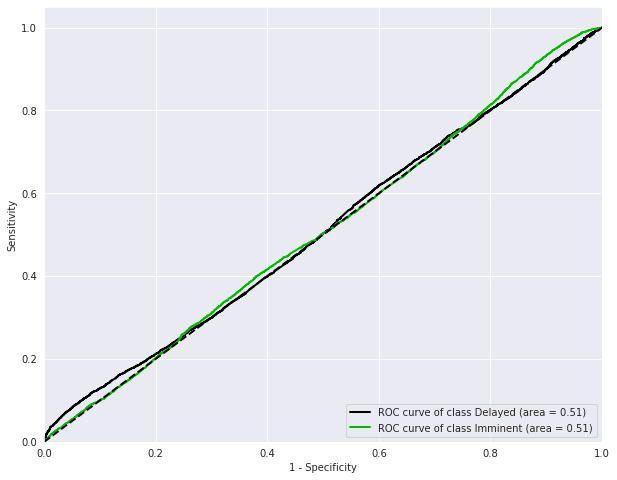

In [8]:
fig, ax = plt.subplots(figsize=(10,8))
plot_roc(label_test, prob, title='', ax=ax, plot_micro=False, plot_macro=False)
ax.set_xlabel('1 - Specificity')
ax.set_ylabel('Sensitivity')

(0.28, 0.28)


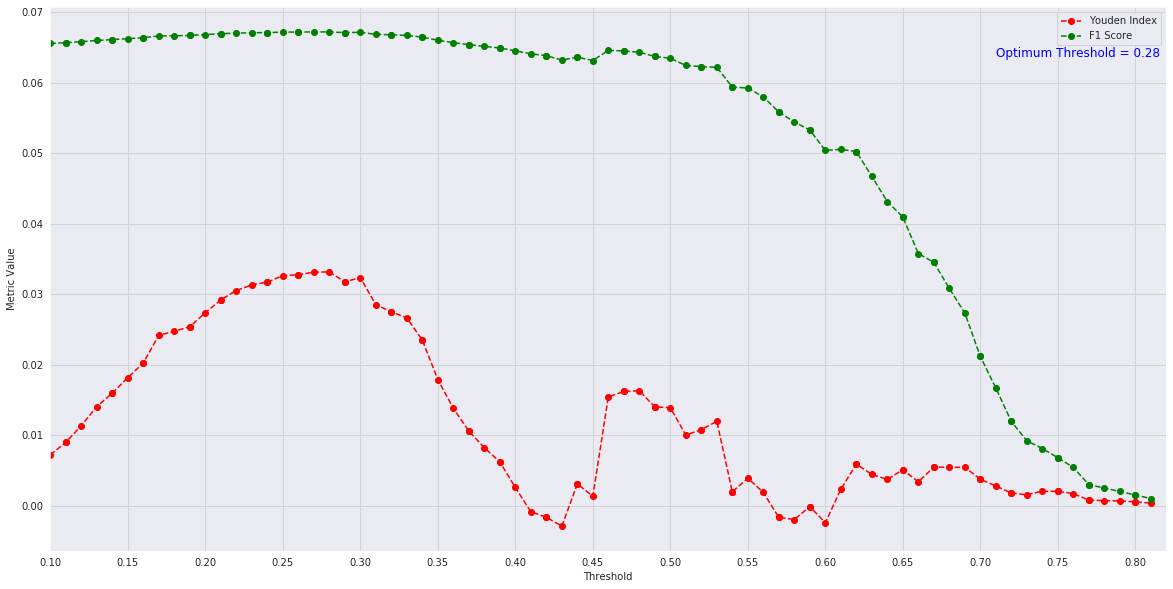

In [9]:
fig, ax = plt.subplots(figsize=(20, 10))
best_threshold = plot_thresh_metric(ax, y_test_mlh, pos_prob, lower=0.1, upper=0.81, n_vals=100)
ax.text(0.71, ax.get_ylim()[1] * 0.9, f'Optimum Threshold = {best_threshold[0]}', fontsize=12, color='b')
print(best_threshold)

if save:
  fig.savefig(args.figdir/f'{args.model}_threshold_guide.pdf', dpi=300)

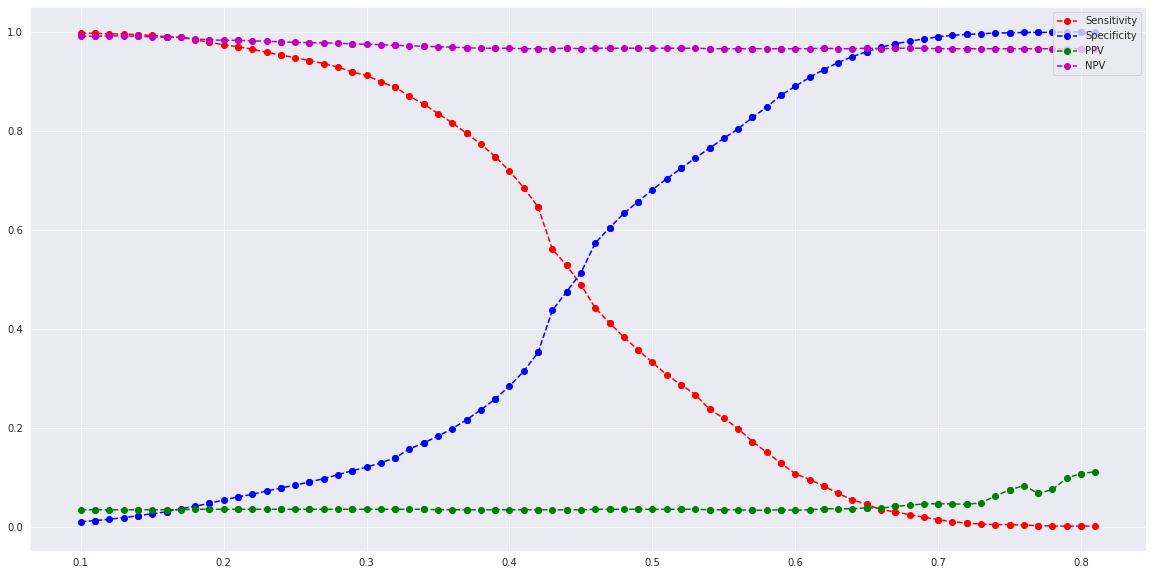

In [10]:
fig, ax = plt.subplots(figsize=(20, 10))
plot_thresh_range(ax, y_test_mlh, pos_prob, lower=0.1, upper=0.81, n_vals=100)

if save:
  fig.savefig(args.figdir/f'{args.model}_metrics_vary.pdf', dpi=300)

In [11]:
threshold = 0.28
pred = (pos_prob > threshold).astype(np.int64)
cm = confusion_matrix(y_test_mlh, pred)
tn,fp,fn,tp = cm[0][0],cm[0][1],cm[1][0],cm[1][1]
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
ppv = tp/(tp+fp)
npv = tn/(tn+fn)
f1 = (2*ppv*sensitivity)/(ppv+sensitivity)
auroc = roc_auc_score(y_test_mlh, pos_prob)

d = {
  'sensitivity': np.round(sensitivity, 3),
  'specificity': np.round(specificity, 3),
  'ppv': np.round(ppv, 3),
  'npv': np.round(npv, 3),
  'f1': np.round(f1, 3),
  'auroc': np.round(auroc, 3),
  'threshold': threshold,
}
metrics = pd.DataFrame(d.values(), index=d.keys(), columns=['Value'])
metrics

,Value
sensitivity,0.929
specificity,0.105
ppv,0.035
npv,0.977
f1,0.067
auroc,0.509
threshold,0.280


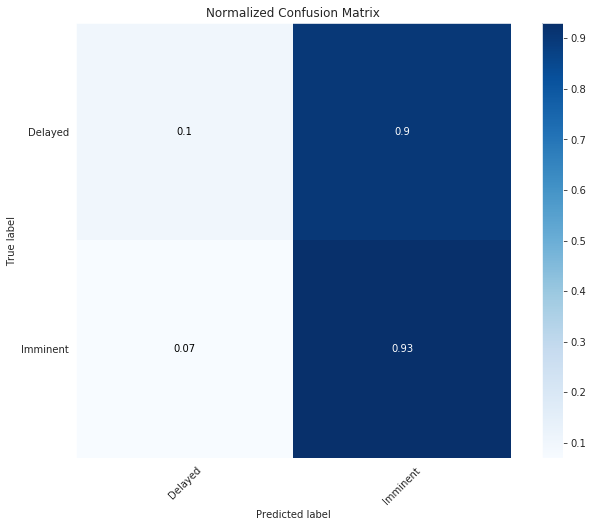

In [12]:
fig, ax = plt.subplots(figsize=(11, 8))
plot_confusion_matrix(label_test, [labels[i] for i in pred], x_tick_rotation=45, ax=ax, normalize=True)

### Cross Training

In [13]:
mlh_cross_df = set_group_splits(mlh_notes_df.copy(), group_col='hadm_id', seed=seed, pct=0.9)

train_df = mlh_cross_df[mlh_cross_df['split'] == 'train'][['note', 'imi_adm_label']]
test_df = mlh_cross_df[mlh_cross_df['split'] == 'test'][['note', 'imi_adm_label']]

In [14]:
# x_train_cross_mlh = mimic2mlh_vec.transform(train_df['note'])
# x_test_cross_mlh = mimic2mlh_vec.transform(test_df['note'])

# with open(args.vectordir/f'mimic2mlh_643.pkl', 'wb') as f:
#   pickle.dump(x_train_cross_mlh, f)
#   pickle.dump(x_test_cross_mlh, f)

with open(args.vectordir/f'mimic2mlh_643.pkl', 'rb') as f:
  x_train_cross_mlh = pickle.load(f)
  x_test_cross_mlh = pickle.load(f)

y_train_cross_mlh, y_test_cross_mlh = train_df['imi_adm_label'], test_df['imi_adm_label']
x_train_cross_mlh.shape, y_train_cross_mlh.shape, x_test_cross_mlh.shape, y_test_cross_mlh.shape

((11043, 60000), (11043,), (105357, 60000), (105357,))

In [15]:
clf = pickle.load( open(args.modeldir/'mimic_full.pkl', 'rb'))
clf.fit(x_train_cross_mlh, y_train_cross_mlh)

prob = clf.predict_proba(x_test_cross_mlh)
pos_prob = prob[:, 1]

labels = ['Delayed', 'Imminent']
label_test = [labels[i] for i in y_test_cross_mlh]

Text(0, 0.5, 'Sensitivity')

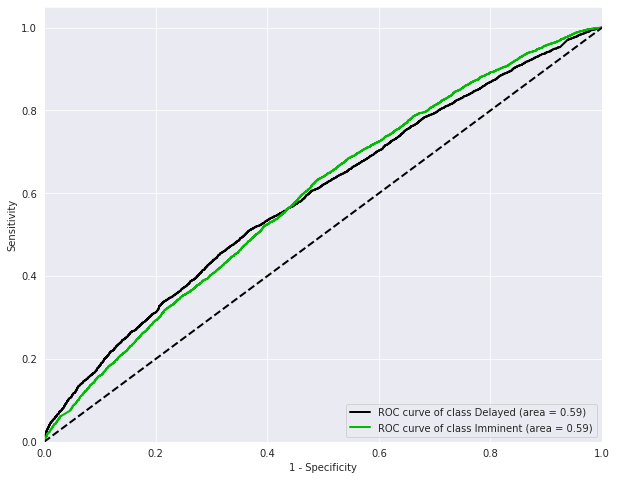

In [16]:
fig, ax = plt.subplots(figsize=(10,8))
plot_roc(label_test, prob, title='', ax=ax, plot_micro=False, plot_macro=False)
ax.set_xlabel('1 - Specificity')
ax.set_ylabel('Sensitivity')

In [21]:
threshold = 0.12
pred = (pos_prob > threshold).astype(np.int64)
cm = confusion_matrix(y_test_cross_mlh, pred)
tn,fp,fn,tp = cm[0][0],cm[0][1],cm[1][0],cm[1][1]
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
ppv = tp/(tp+fp)
npv = tn/(tn+fn)
f1 = (2*ppv*sensitivity)/(ppv+sensitivity)
auroc = roc_auc_score(y_test_cross_mlh, pos_prob)

d = {
  'sensitivity': np.round(sensitivity, 3),
  'specificity': np.round(specificity, 3),
  'ppv': np.round(ppv, 3),
  'npv': np.round(npv, 3),
  'f1': np.round(f1, 3),
  'auroc': np.round(auroc, 3),
  'threshold': threshold,
}
metrics = pd.DataFrame(d.values(), index=d.keys(), columns=['Value'])
metrics

,Value
sensitivity,0.601
specificity,0.534
ppv,0.042
npv,0.975
f1,0.079
auroc,0.592
threshold,0.120


### Metrics

In [35]:
with open(args.workdir/args.model/f'mimic_mlh_preds.pkl', 'rb') as f:
  targs = pickle.load(f)
  probs = pickle.load(f)
  preds = pickle.load(f)

bam = BinaryAvgMetrics(targs, preds, [prob[:, 1] for prob in probs])
bam.get_avg_metrics(defn=True)

,Value,Definition
sensitivity,0.565,"When it's ACTUALLY YES, how often does it PREDICT YES?"
specificity,0.595,"When it's ACTUALLY NO, how often does it PREDICT NO?"
ppv,0.046,"When it PREDICTS YES, how often is it correct?"
auroc,0.614,Indicates how well the model is capable of distinguishing between classes
npv,0.975,"When it PREDICTS NO, how often is it correct?"
f1,0.086,Harmonic mean of sensitivity and ppv


In [36]:
bam.get_avg_metrics(conf=0.95)

,Mean,Lower,Upper
sensitivity,0.565,0.278,0.852
specificity,0.595,0.305,0.885
ppv,0.046,0.034,0.058
auroc,0.614,0.602,0.627
npv,0.975,0.970,0.981
f1,0.086,0.069,0.103


## MLH -> MIMIC

### MIMIC LR Development

In [22]:
with open(args.vectordir/f'mlh2mimic.pkl', 'rb') as f:
  mlh2mimic_vec = pickle.load(f)
  x_train_mlh = pickle.load(f)
  x_test_mimic = pickle.load(f)
  y_train_mlh = pickle.load(f)
  y_test_mimic = pickle.load(f)
  
x_train_mlh.shape, y_train_mlh.shape, x_test_mimic.shape, y_test_mimic.shape

((116400, 60000), (116400,), (38112, 60000), (38112,))

In [23]:
lgb_params = {
  'objective': 'binary',
  'metric': 'binary_logloss',  
  'is_unbalance': True,
  'learning_rate': 0.05,
  'max_bin': 16,
  'feature_fraction': 0.5,
}

clf = lgb.LGBMClassifier(**lgb_params)

clf.fit(x_train_mlh, y_train_mlh)
pickle.dump(clf, open(args.modeldir/'mlh_full.pkl', 'wb'))

### Cross Testing

In [24]:
prob = clf.predict_proba(x_test_mimic)
pos_prob = prob[:, 1]

labels = ['Delayed', 'Imminent']
label_test = [labels[i] for i in y_test_mimic]

Text(0, 0.5, 'Sensitivity')

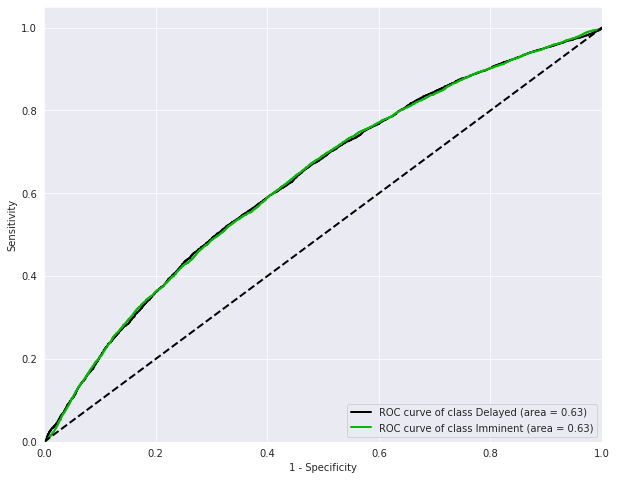

In [25]:
fig, ax = plt.subplots(figsize=(10,8))
plot_roc(label_test, prob, title='', ax=ax, plot_micro=False, plot_macro=False)
ax.set_xlabel('1 - Specificity')
ax.set_ylabel('Sensitivity')

../../utils/plots.py:206: RuntimeWarning: invalid value encountered in true_divide
  ppv = cms[:, 1, 1] / (cms[:, 1, 1] + cms[:, 0, 1])


(0.46, None)


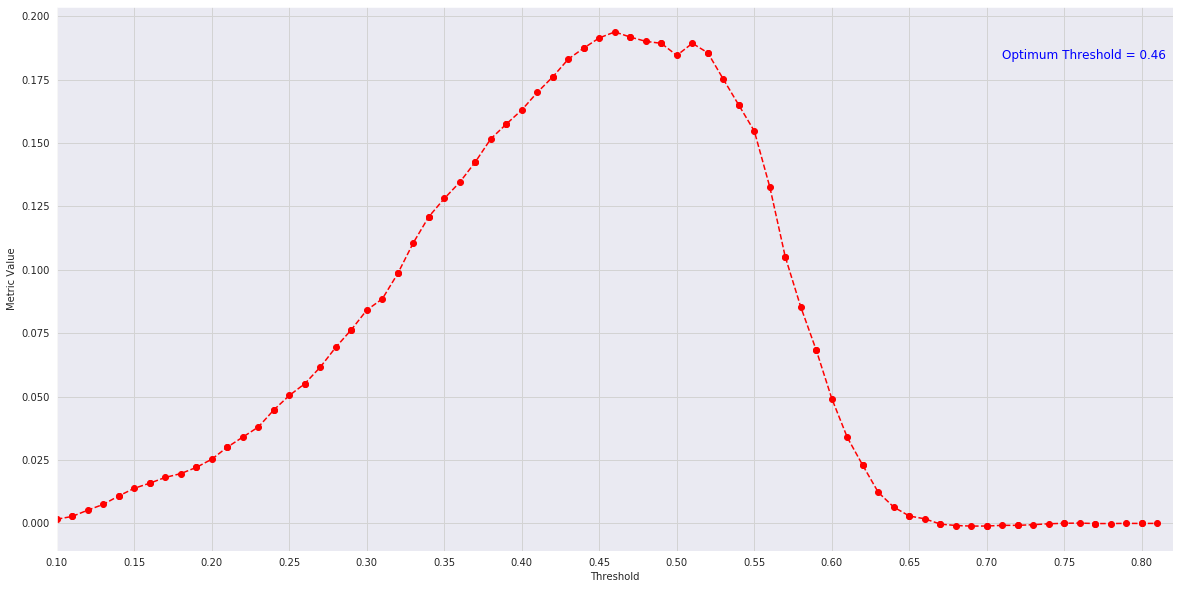

In [26]:
fig, ax = plt.subplots(figsize=(20, 10))
best_threshold = plot_thresh_metric(ax, y_test_mimic, pos_prob, lower=0.1, upper=0.81, n_vals=100, show_f1=False)
ax.text(0.71, ax.get_ylim()[1] * 0.9, f'Optimum Threshold = {best_threshold[0]}', fontsize=12, color='b')
print(best_threshold)

if save:
  fig.savefig(args.figdir/f'{args.model}_threshold_guide.pdf', dpi=300)

../../utils/plots.py:138: RuntimeWarning: invalid value encountered in long_scalars
  metrics[2][i] = np.round(tp/(tp+fp), 3)


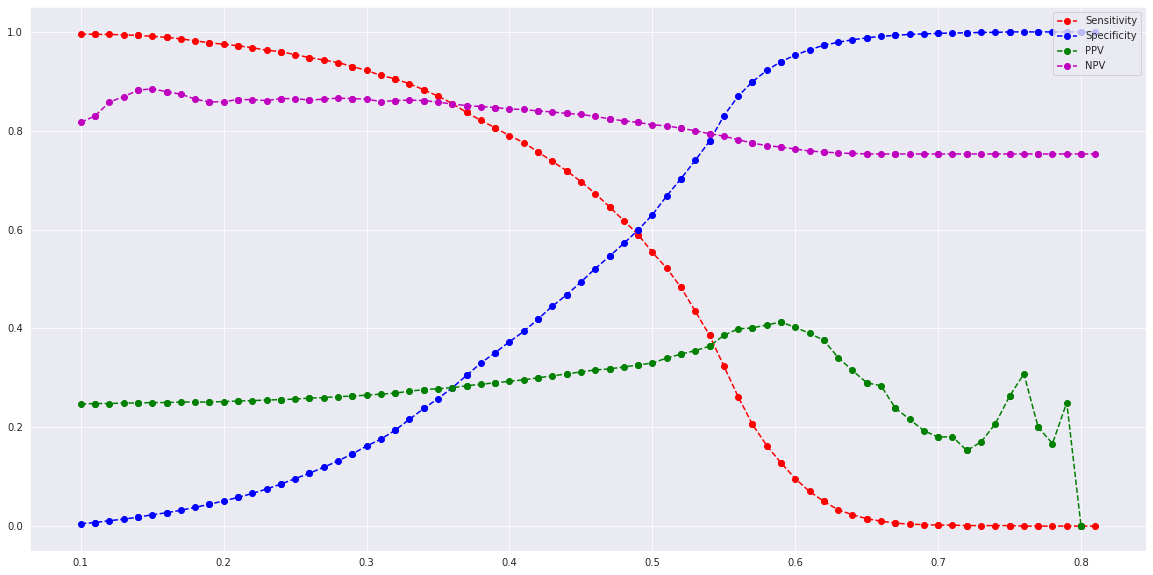

In [27]:
fig, ax = plt.subplots(figsize=(20, 10))
plot_thresh_range(ax, y_test_mimic, pos_prob, lower=0.1, upper=0.81, n_vals=100)

if save:
  fig.savefig(args.figdir/f'{args.model}_metrics_vary.pdf', dpi=300)

In [28]:
threshold = 0.46
pred = (pos_prob > threshold).astype(np.int64)
cm = confusion_matrix(y_test_mimic, pred)
tn,fp,fn,tp = cm[0][0],cm[0][1],cm[1][0],cm[1][1]
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
ppv = tp/(tp+fp)
npv = tn/(tn+fn)
f1 = (2*ppv*sensitivity)/(ppv+sensitivity)
auroc = roc_auc_score(y_test_mimic, pos_prob)

d = {
  'sensitivity': np.round(sensitivity, 3),
  'specificity': np.round(specificity, 3),
  'ppv': np.round(ppv, 3),
  'npv': np.round(npv, 3),
  'f1': np.round(f1, 3),
  'auroc': np.round(auroc, 3),
  'threshold': threshold,
}
metrics = pd.DataFrame(d.values(), index=d.keys(), columns=['Value'])
metrics

,Value
sensitivity,0.673
specificity,0.521
ppv,0.316
npv,0.829
f1,0.430
auroc,0.631
threshold,0.460


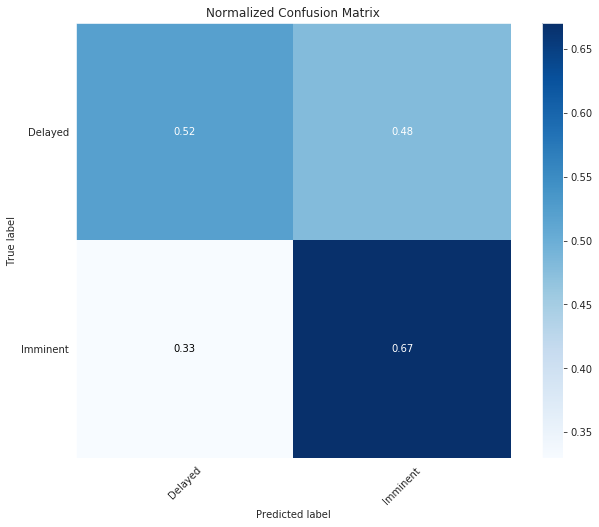

In [29]:
fig, ax = plt.subplots(figsize=(11, 8))
plot_confusion_matrix(label_test, [labels[i] for i in pred], x_tick_rotation=45, ax=ax, normalize=True)

### Cross Training

In [30]:
mimic_cross_df = set_group_splits(mimic_notes_df.copy(), group_col='hadm_id', seed=seed, pct=0.9)

train_df = mimic_cross_df[mimic_cross_df['split'] == 'train'][['note', 'imi_adm_label']]
test_df = mimic_cross_df[mimic_cross_df['split'] == 'test'][['note', 'imi_adm_label']]

In [31]:
# x_train_cross_mimic = mlh2mimic_vec.transform(train_df['note'])
# x_test_cross_mimic = mlh2mimic_vec.transform(test_df['note'])

# with open(args.vectordir/f'mlh2mimic_643.pkl', 'wb') as f:
#   pickle.dump(x_train_cross_mimic, f)
#   pickle.dump(x_test_cross_mimic, f)

with open(args.vectordir/f'mlh2mimic_643.pkl', 'rb') as f:
  x_train_cross_mimic = pickle.load(f)
  x_test_cross_mimic = pickle.load(f)

y_train_cross_mimic, y_test_cross_mimic = train_df['imi_adm_label'], test_df['imi_adm_label']
x_train_cross_mimic.shape, y_train_cross_mimic.shape, x_test_cross_mimic.shape, y_test_cross_mimic.shape

((4452, 60000), (4452,), (33660, 60000), (33660,))

In [32]:
clf = pickle.load( open(args.modeldir/'mlh_full.pkl', 'rb'))
clf.fit(x_train_cross_mimic, y_train_cross_mimic)

prob = clf.predict_proba(x_test_cross_mimic)
pos_prob = prob[:, 1]

labels = ['Delayed', 'Imminent']
label_test = [labels[i] for i in y_test_cross_mimic]

Text(0, 0.5, 'Sensitivity')

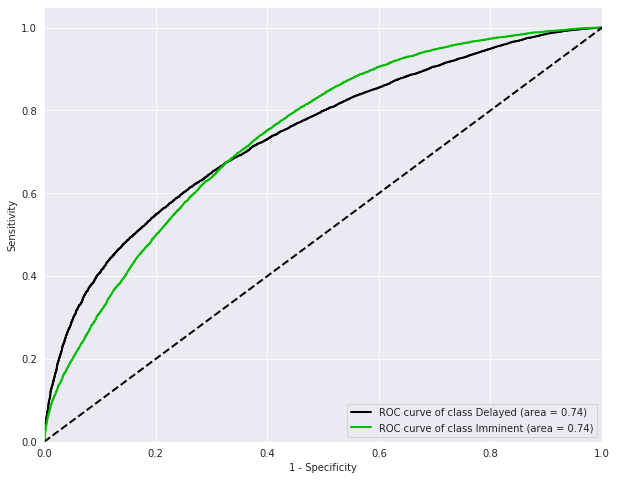

In [34]:
fig, ax = plt.subplots(figsize=(10,8))
plot_roc(label_test, prob, title='', ax=ax, plot_micro=False, plot_macro=False)
ax.set_xlabel('1 - Specificity')
ax.set_ylabel('Sensitivity')

In [40]:
threshold = 0.4
pred = (pos_prob > threshold).astype(np.int64)
cm = confusion_matrix(y_test_cross_mimic, pred)
tn,fp,fn,tp = cm[0][0],cm[0][1],cm[1][0],cm[1][1]
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
ppv = tp/(tp+fp)
npv = tn/(tn+fn)
f1 = (2*ppv*sensitivity)/(ppv+sensitivity)
auroc = roc_auc_score(y_test_cross_mimic, pos_prob)

d = {
  'sensitivity': np.round(sensitivity, 3),
  'specificity': np.round(specificity, 3),
  'ppv': np.round(ppv, 3),
  'npv': np.round(npv, 3),
  'f1': np.round(f1, 3),
  'auroc': np.round(auroc, 3),
  'threshold': threshold,
}
metrics = pd.DataFrame(d.values(), index=d.keys(), columns=['Value'])
metrics

,Value
sensitivity,0.744
specificity,0.608
ppv,0.387
npv,0.877
f1,0.509
auroc,0.741
threshold,0.400


### Metrics

In [37]:
with open(args.workdir/args.model/f'mlh_mimic_preds.pkl', 'rb') as f:
  targs = pickle.load(f)
  probs = pickle.load(f)
  preds = pickle.load(f)

bam = BinaryAvgMetrics(targs, preds, [prob[:, 1] for prob in probs])
bam.get_avg_metrics(defn=True)

,Value,Definition
sensitivity,0.698,"When it's ACTUALLY YES, how often does it PREDICT YES?"
specificity,0.638,"When it's ACTUALLY NO, how often does it PREDICT NO?"
ppv,0.388,"When it PREDICTS YES, how often is it correct?"
auroc,0.732,Indicates how well the model is capable of distinguishing between classes
npv,0.865,"When it PREDICTS NO, how often is it correct?"
f1,0.499,Harmonic mean of sensitivity and ppv


In [38]:
bam.get_avg_metrics(conf=0.95)

,Mean,Lower,Upper
sensitivity,0.698,0.569,0.827
specificity,0.638,0.454,0.823
ppv,0.388,0.318,0.458
auroc,0.732,0.684,0.781
npv,0.865,0.853,0.878
f1,0.499,0.474,0.524


## Metrics

In [ ]:
with open(args.workdir/f'preds.pkl', 'rb') as f:
  targs = pickle.load(f)
  probs = pickle.load(f)
  preds = pickle.load(f)

bam = BinaryAvgMetrics(targs, preds, [prob[:, 1] for prob in probs])
bam.get_avg_metrics(defn=True)

In [ ]:
bam.get_avg_metrics(conf=0.95)

In [ ]:
fig, ax = plt.subplots(figsize=(11, 8))
plot_cm(ax, bam.cm_avg, ['Delayed', 'Imminent'])

if save:
  fig.savefig(args.figdir/f'mean_cm.pdf', dpi=300)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_mean_roc(ax, bam.targs, probs)

if save:
  fig.savefig(args.figdir/f'mean_roc.pdf', dpi=300)